In [1]:
import sys
sys.path.append('../')
import torch.optim as optim
from dataset import *
from model import *
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter

Train_epoch:0    MAE:105.88792257815989   Pure:105.86463500051887
Train_epoch:10    MAE:5.731468854881918   Pure:5.645953079237138
Test_epoch:10    MAE_test:10.654514961490666


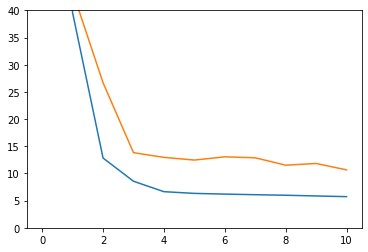

Train_epoch:20    MAE:4.695681710463333   Pure:4.602382458787729
Test_epoch:20    MAE_test:7.37290083864809


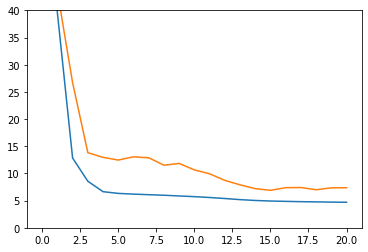

Train_epoch:30    MAE:3.7681201029637172   Pure:3.671187135753902
Test_epoch:30    MAE_test:26.77303016656519


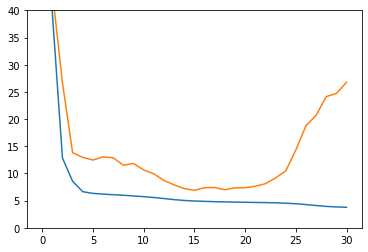

Train_epoch:40    MAE:3.4598372460434113   Pure:3.359918461663452
Test_epoch:40    MAE_test:23.349602732474057


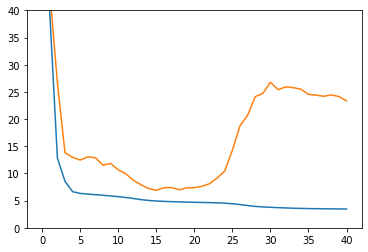

Train_epoch:50    MAE:3.315115352362168   Pure:3.2139122013983856
Test_epoch:50    MAE_test:22.38181009848815


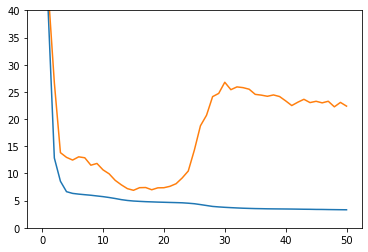

Train_epoch:60    MAE:3.2538151046432944   Pure:3.1516561408080546
Test_epoch:60    MAE_test:22.55166943123567


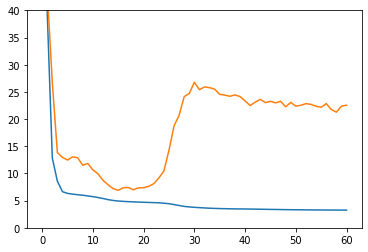

Train_epoch:70    MAE:3.212220831223834   Pure:3.1095703631485585
Test_epoch:70    MAE_test:21.536775357011745


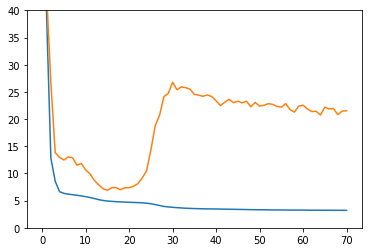

Train_epoch:80    MAE:3.2077926611454237   Pure:3.105207493594383
Test_epoch:80    MAE_test:20.74161505744001


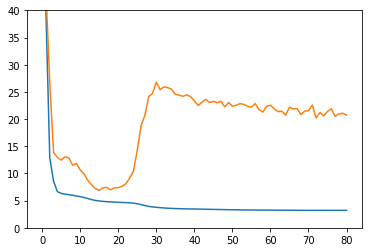

Train_epoch:90    MAE:3.205084054519001   Pure:3.102702209628883
Test_epoch:90    MAE_test:21.038260369231484


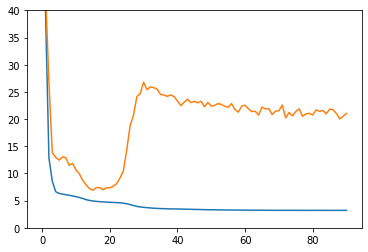

Train_epoch:100    MAE:3.2054290989291365   Pure:3.1033024849545656
Test_epoch:100    MAE_test:20.55039010839562


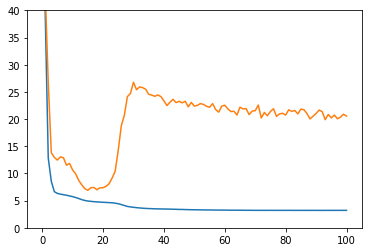

Train_epoch:110    MAE:3.207730880216963   Pure:3.10584149673403
Test_epoch:110    MAE_test:19.83213221688745


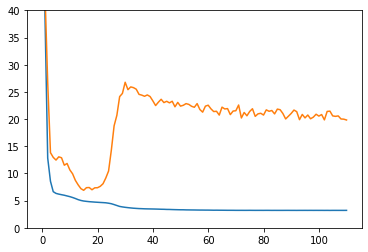

Train_epoch:120    MAE:3.204299479501631   Pure:3.102613382022765
Test_epoch:120    MAE_test:20.212335817450953


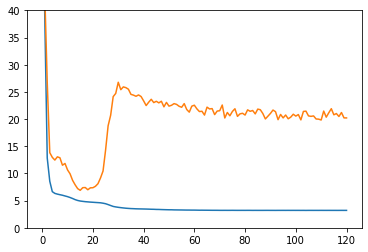

Train_epoch:130    MAE:3.2052117222658216   Pure:3.10373203667317
Test_epoch:130    MAE_test:20.077077293813918


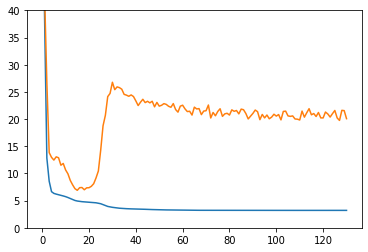

Train_epoch:140    MAE:3.1986435769507873   Pure:3.097359082479238
Test_epoch:140    MAE_test:21.18837593581553


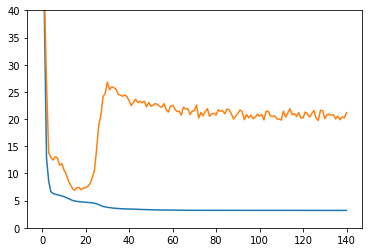

Train_epoch:150    MAE:3.206074239325186   Pure:3.105033629536292
Test_epoch:150    MAE_test:20.790315991223423


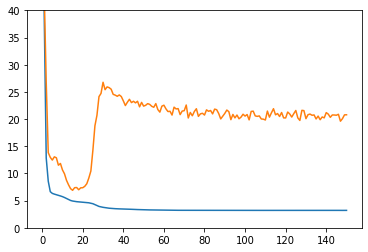

Train_epoch:160    MAE:3.203496122183257   Pure:3.102641294588499
Test_epoch:160    MAE_test:20.553181399120017


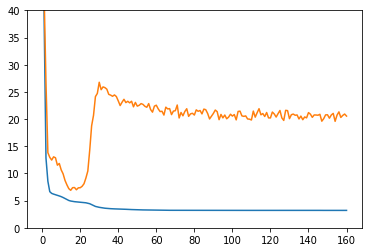

Train_epoch:170    MAE:3.205001397608458   Pure:3.104347946797549
Test_epoch:170    MAE_test:20.21873398526512


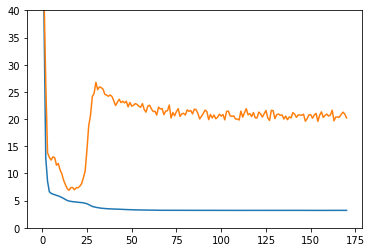

Train_epoch:180    MAE:3.1979850459305847   Pure:3.0975088343827335
Test_epoch:180    MAE_test:21.07432333670632


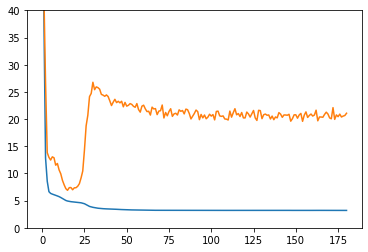

Train_epoch:190    MAE:3.1995078179466354   Pure:3.099245727049075
Test_epoch:190    MAE_test:20.608584168977714


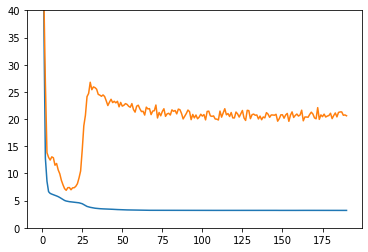

Train_epoch:200    MAE:3.2004287252970123   Pure:3.1003473735876463
Test_epoch:200    MAE_test:20.447172233775387


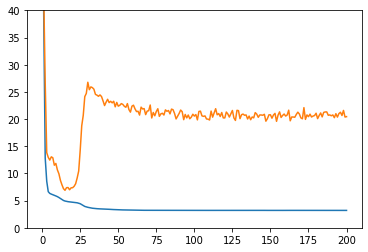

Train_epoch:210    MAE:3.2009086753850458   Pure:3.1010054473405364
Test_epoch:210    MAE_test:20.25427269648135


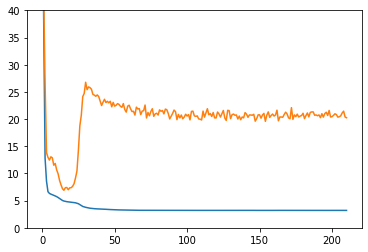

Train_epoch:220    MAE:3.2007424647523526   Pure:3.101047575540698
Test_epoch:220    MAE_test:21.418118077419418


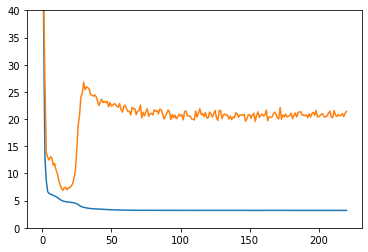

Train_epoch:230    MAE:3.1981573562389713   Pure:3.0986249686485627
Test_epoch:230    MAE_test:20.364777323288358


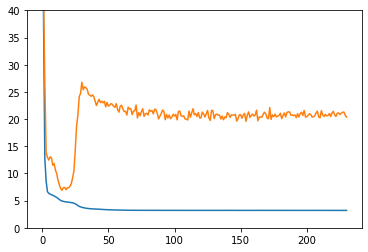

Train_epoch:240    MAE:3.203520591895876   Pure:3.1041837898424247
Test_epoch:240    MAE_test:20.1399151677535


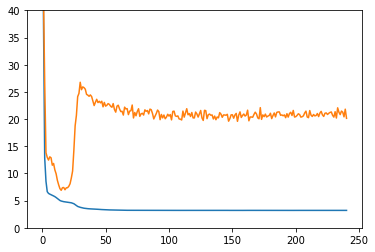

Train_epoch:250    MAE:3.197456390658543   Pure:3.098253346744702
Test_epoch:250    MAE_test:20.585254520203687


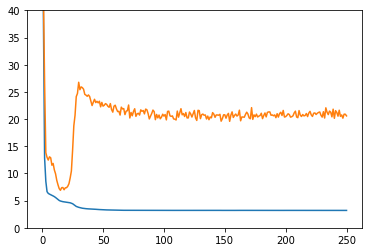

Train_epoch:260    MAE:3.1984117547668958   Pure:3.0994098449625516
Test_epoch:260    MAE_test:20.545361601716326


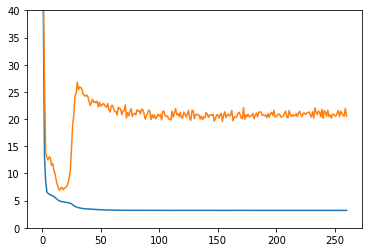

Train_epoch:270    MAE:3.203983549948209   Pure:3.1051584512429167
Test_epoch:270    MAE_test:21.165402436130968


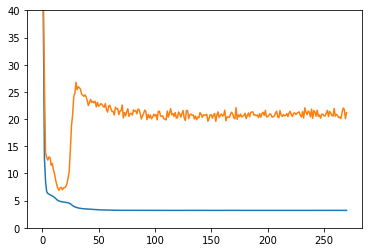

Train_epoch:360    MAE:3.195137130641659   Pure:3.097810587691983
Test_epoch:360    MAE_test:21.02418645789885


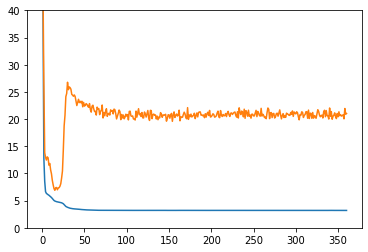

Train_epoch:370    MAE:3.1978264075177396   Pure:3.1006696177023136
Test_epoch:370    MAE_test:20.59789226611777


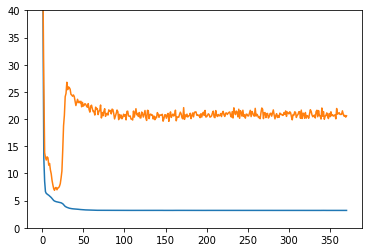

Train_epoch:380    MAE:3.19703147737533   Pure:3.1000359952285907
Test_epoch:380    MAE_test:20.694798620773128


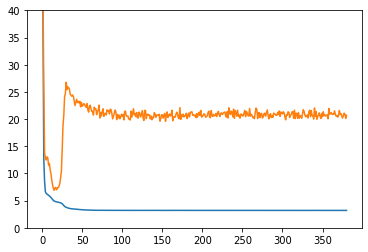

Train_epoch:390    MAE:3.197702307441071   Pure:3.100907939746216
Test_epoch:390    MAE_test:21.250836932727058


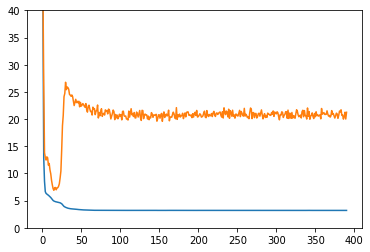

Train_epoch:400    MAE:3.200811626145952   Pure:3.104140015778653
Test_epoch:400    MAE_test:19.869511847605548


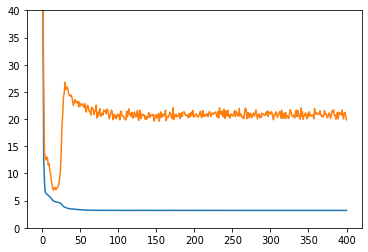

Train_epoch:410    MAE:3.198589168630392   Pure:3.1020923309190582
Test_epoch:410    MAE_test:20.497944794534554


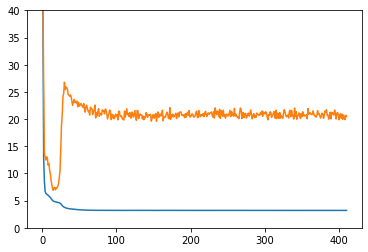

Train_epoch:420    MAE:3.200147491201633   Pure:3.103774500974888
Test_epoch:420    MAE_test:21.35723214656856


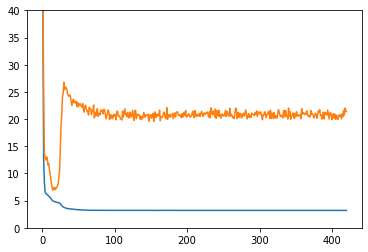

Train_epoch:430    MAE:3.1961210166312113   Pure:3.0999299632049455
Test_epoch:430    MAE_test:20.84707148388362


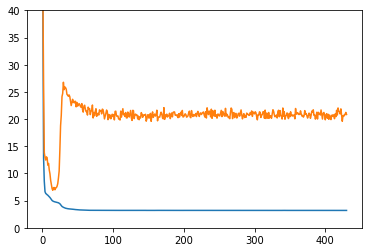

Train_epoch:440    MAE:3.1971306706179496   Pure:3.1010637746800302
Test_epoch:440    MAE_test:21.439513176008234


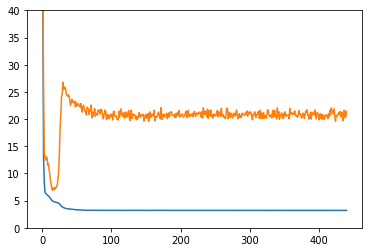

Train_epoch:450    MAE:3.1963027115784253   Pure:3.1004155286274524
Test_epoch:450    MAE_test:19.62319269969995


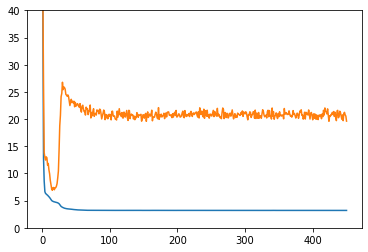

Train_epoch:460    MAE:3.1941524771371066   Pure:3.0984090620436846
Test_epoch:460    MAE_test:20.979178648938905


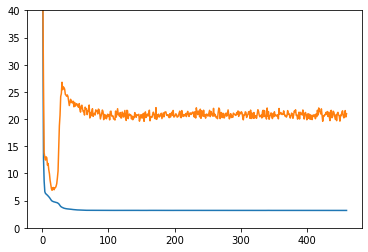

Train_epoch:470    MAE:3.194351417897452   Pure:3.0987662743790043
Test_epoch:470    MAE_test:20.009063461673836


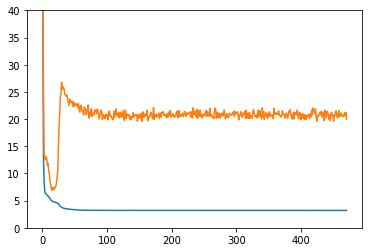

Train_epoch:480    MAE:3.193121969367922   Pure:3.0976599820870763
Test_epoch:480    MAE_test:20.341819573155494


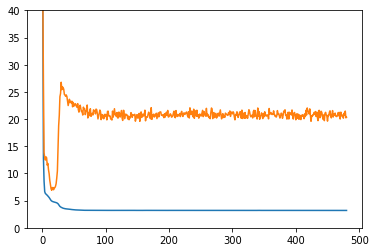

Train_epoch:490    MAE:3.191708715473055   Pure:3.09642166648948
Test_epoch:490    MAE_test:20.157732064328407


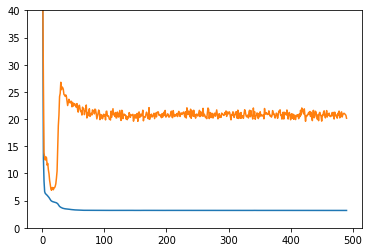

Train_epoch:500    MAE:3.196053941048973   Pure:3.1009018482106856
Test_epoch:500    MAE_test:21.348689312701023


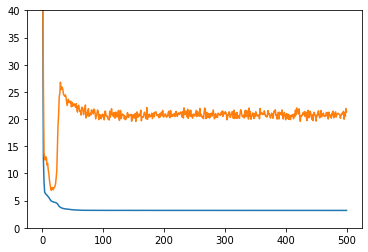

In [2]:
s_or_d = "s"
unrelated_feature_number = 0
feature_number = 3

train_log = np.array([])
test_log = np.array([])

# writer = {
#     'train': SummaryWriter('../logs/OTO/train'), #必须要不同的writer
#     'test': SummaryWriter('../logs/OTO/test'),
# }

batchsize = 32
lambda_l1 = 0.001  # 正则化系数
lambda_selection = 0

criterion = nn.L1Loss()
criterion = criterion.cuda()

model = MLP(feature_number).cuda().double()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# adaptive learning rate
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)


# tmp = np.load("../data/simu_20000_0.1_90_140_train.npy")
# if s_or_d == 0:
#     max = np.max(tmp[:, 1004])
#     min = np.min(tmp[:, 1004])
# else:
#     max = np.max(tmp[:, 1005])
#     min = np.min(tmp[:, 1005])


train_dataset = Dataset("../data/features_rand_train.npy", s_or_d, "train", unrelated_feature_number)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = Dataset("../data/features_rand_test.npy", s_or_d, "test", unrelated_feature_number)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

for epoch in range(501):
    
    # print(f"Learning Rate (Single LR): {optimizer.param_groups[0]['lr']}")
    
    model.train()

    loss_total = 0
    step = 0
    loss_pure = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        # print(data.shape)

        # target = (target - min) / (max - min)

        output = model(data)

        loss = criterion(output, target)
        
        loss_pure = loss_pure + loss.item()
        
        l1_regularization = torch.tensor(0.0).cuda()
        
        for param in model.seq.parameters():
            l1_regularization += torch.norm(param, p=1)
        
        
        loss = loss + l1_regularization * lambda_l1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total = loss_total + loss.item()
        step = step + 1
    
    # scheduler.step()
    
    # writer["train"].add_scalar('FS', loss_total/step, epoch)  
    train_log = np.append(train_log, loss_total/step)
    
    # tmp = '../pth/tmp_%d_%.2f.pth' % (epoch, loss_total/step)
    
    if epoch % 10 == 0:
        # torch.save(model, tmp)
        print("Train_epoch:" + str(epoch) + "    MAE:" + str(loss_total/step) + "   Pure:" + str(loss_pure/step))

    loss_test = 0
    step = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)

            # inv_norm
            # output = output * (max - min) + min

            loss = criterion(output, target)

            loss_test += loss.item()
            step += 1

        loss_mean = loss_test / step
        
        # writer["test"].add_scalar('FS', loss_mean, epoch) 
        test_log = np.append(test_log, loss_mean)
        
        if epoch % 10 == 0 and epoch != 0:
            print("Test_epoch:" + str(epoch) + "    MAE_test:" + str(loss_mean))
            # tmp_epoch = np.arange(epoch+1)
            # print(tmp_epoch)
            plt.plot(train_log)
            plt.plot(test_log)
            plt.ylim(0,40)
            plt.show()